<h1>Proof of Case & Use pyMagicStat-Alpha V 0.02</h1>

In [151]:
import sys
import shutil
import os

# Ruta del paquete
PYMAGICSTAT_PATH = r'C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat'

# Limpiar caché de módulos
pycache_path = os.path.join(PYMAGICSTAT_PATH, '__pycache__')
if os.path.exists(pycache_path):
    shutil.rmtree(pycache_path)

# Limpiar módulos cargados previamente
MODULES_TO_CLEAR = [mod for mod in sys.modules if mod.startswith("pyMagicStat")]
for module in MODULES_TO_CLEAR:
    del sys.modules[module]

# Asegurar que el path está correcto
if PYMAGICSTAT_PATH not in sys.path:
    sys.path.append(PYMAGICSTAT_PATH)


In [152]:
# Configuración inicial para cargar el proyecto y limpiar la caché
import sys
import os
from importlib import reload
import shutil
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Ruta al directorio raíz del proyecto
PROJECT_ROOT = r'C:\Users\ehudb\OneDrive\Desktop\pyMagicStat'

# Asegurarse de que el proyecto está en sys.path
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Ruta al directorio pyMagicStat
PYMAGICSTAT_PATH = os.path.join(PROJECT_ROOT, 'pyMagicStat')

# Limpiar caché de módulos
def clean_pycache():
    pycache_path = os.path.join(PYMAGICSTAT_PATH, '__pycache__')
    if os.path.exists(pycache_path):
        shutil.rmtree(pycache_path)
        print(f"Eliminado caché en: {pycache_path}")
    else:
        print("No se encontró caché para limpiar.")

clean_pycache()

# Limpiar módulos cargados previamente
MODULES_TO_CLEAR = [
    "pyMagicStat.distributions",
    "pyMagicStat.confidence_intervals",
    "pyMagicStat.utils",
    "pyMagicStat.distributionOrchestrator",
]
for module in MODULES_TO_CLEAR:
    if module in sys.modules:
        del sys.modules[module]

# Importar módulos principales
import pyMagicStat.lib.utils as utils
import pyMagicStat.Classes.confidence_intervals as ci
import pyMagicStat.Classes.distributions as dist



# Recargar módulos para reflejar cambios
reload(ci)
reload(dist)
reload(utils)


# Importar clases específicas necesarias
from pyMagicStat.Classes.confidence_intervals import (
    ConfidenceIntervals,
    NormalDistConfidenceIntervals,
    PopulationMeanCI,
    PopulationProportionCI,
    PopulationVarianceCI,
    BootstrapConfidenceIntervals,
    BootstrapMeanCI,
    BootstrapMedianCI,
    BootstrapVarianceCI,
    BootstrapProportionCI,
)
from pyMagicStat.Classes.distributions import (
    Distribution,
    DistributionTest,
    NormalDistribution,
    BinomialDistribution,
    PoissonDistribution,
    LognormalDistribution,
    GoodnessAndFit
)
from pyMagicStat.lib.utils import output_format, validate_non_nan
 

# Validación del entorno
print("Módulos pyMagicStat cargados y listos para usar.")


No se encontró caché para limpiar.
Módulos pyMagicStat cargados y listos para usar.


In [153]:
print(Distribution.__module__)

pyMagicStat.Classes.distributions


In [154]:


def normal_ci_mean(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    stderr = np.std(data, ddof=1) / np.sqrt(n)
    margin = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean - margin, mean + margin

def bootstrap_ci(data, func=np.mean, confidence=0.95, n_bootstraps=1000):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True)
    stat = np.array([func(sample) for sample in bootstraps])
    lower = np.percentile(stat, (1-confidence)/2*100)
    upper = np.percentile(stat, (1+confidence)/2*100)
    return lower, upper

def audit_precision(data, n_bootstraps=1000, confidence=0.95):
    results = {
        'mean': {'normal': {}, 'bootstrap': {}},
        'variance': {'normal': {}, 'bootstrap': {}},
        'proportion': {'normal': {}, 'bootstrap': {}},
        'median': {'normal': {}, 'bootstrap': {}}
    }
    
    # Media
    results['mean']['normal']['ci'] = normal_ci_mean(data, confidence)
    results['mean']['bootstrap']['ci'] = bootstrap_ci(data, np.mean, confidence, n_bootstraps)
    results['mean']['actual'] = np.mean(data)
    
    # Varianza
    variance_normal = np.var(data, ddof=1)
    ci_variance = (variance_normal - 1.96*np.sqrt(2*variance_normal**2/(len(data)-1)),
                   variance_normal + 1.96*np.sqrt(2*variance_normal**2/(len(data)-1)))
    results['variance']['normal']['ci'] = ci_variance
    results['variance']['bootstrap']['ci'] = bootstrap_ci(data, np.var, confidence, n_bootstraps)
    results['variance']['actual'] = variance_normal
    
    # Proporción Poblacional
    prop = np.mean(data > 0)
    n = len(data)
    se_prop = np.sqrt(prop * (1 - prop) / n)
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
    ci_prop = (prop - z_score * se_prop, prop + z_score * se_prop)
    results['proportion']['normal']['ci'] = ci_prop
    results['proportion']['bootstrap']['ci'] = bootstrap_ci(data, lambda x: np.mean(x > 0), confidence, n_bootstraps)
    results['proportion']['actual'] = prop
    
    # Mediana
    results['median']['normal']['ci'] = (np.median(data) - 1.96 * np.std(data) / np.sqrt(len(data)),
                                         np.median(data) + 1.96 * np.std(data) / np.sqrt(len(data)))
    results['median']['bootstrap']['ci'] = bootstrap_ci(data, np.median, confidence, n_bootstraps)
    results['median']['actual'] = np.median(data)
    
    return results

# Generación de datos para diferentes distribuciones




In [155]:
# Lognormal sin aproximación a normal
print("lognormal_no_normal")


lognormal_no_normal = Distribution(np.random.lognormal(mean=0, sigma=1, size=5000))
lognormal_no_normal_results = audit_precision(lognormal_no_normal.data)

r = GoodnessAndFit(lognormal_no_normal)
r.evaluate_fit()
print(lognormal_no_normal.type)
print(lognormal_no_normal.aic_table)

print("\n-------------------------------------------\n")


print("Lognormal con aproximación a normal:")
# Lognormal con aproximación a normal
lognormal_normal_approx = Distribution(np.random.lognormal(mean=0, sigma=0.1, size=5000))
lognormal_normal_approx_results = audit_precision(lognormal_normal_approx.data)
print(lognormal_normal_approx_results)
x = GoodnessAndFit(lognormal_normal_approx)
x.evaluate_fit()
print(lognormal_normal_approx.type)
print(lognormal_normal_approx.aic_table)
print("\n-------------------------------------------\n")

lognormal_no_normal


C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after applying goodness of fit tests.", UserWarning)


{}
{}

-------------------------------------------

Lognormal con aproximación a normal:
{'mean': {'normal': {'ci': (np.float64(0.9996775153419042), np.float64(1.0052427597619904))}, 'bootstrap': {'ci': (np.float64(0.9998310928735926), np.float64(1.0052551497133617))}, 'actual': np.float64(1.0024601375519473)}, 'variance': {'normal': {'ci': (np.float64(0.00967839204976867), np.float64(0.010468218156411108))}, 'bootstrap': {'ci': (np.float64(0.009683433563331588), np.float64(0.010471233990052245))}, 'actual': np.float64(0.010073305103089888)}, 'proportion': {'normal': {'ci': (np.float64(1.0), np.float64(1.0))}, 'bootstrap': {'ci': (np.float64(1.0), np.float64(1.0))}, 'actual': np.float64(1.0)}, 'median': {'normal': {'ci': (np.float64(0.9940256257124214), np.float64(0.9995890684855433))}, 'bootstrap': {'ci': (np.float64(0.9926658541859681), np.float64(0.9999817900403597))}, 'actual': np.float64(0.9968073470989823)}}
{}
{}

-------------------------------------------



C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after applying goodness of fit tests.", UserWarning)


<h3>Lognormal hay que solucionar la falta de presicion en la aproximacion a la normal.</h3>

In [156]:
def binomial_data_test(binomial_instance):
    # Extraemos los parámetros de la instancia
    n = binomial_instance.n
    p = binomial_instance.p

    media_teorica = n * p
    varianza_teorica = n * p * (1 - p)

    # Parámetros empíricos calculados a partir de los datos
    data = binomial_instance.data
    media_empirica = np.mean(data)
    varianza_empirica = np.var(data)

    print(f"n estimado: {n}, p estimado: {p:.4f}")
    print(f"Media teórica: {media_teorica}, Media empírica: {media_empirica}")
    print(f"Varianza teórica: {varianza_teorica}, Varianza empírica: {varianza_empirica}")

print("Binomial sin aproximación a normal:")
# Binomial sin aproximación a normal
#Iniciate de Distribution object 
binomial_no_normal = Distribution(np.random.binomial(n=5, p=0.5, size=5000))
# Distribution.data is where we store de dataframe
print(binomial_no_normal.data)

print("Type de self.data:", type(binomial_no_normal.data))
print("Type de elementos en self.data:", binomial_no_normal.data.dtype)
#binomial_no_normal_results = audit_precision(binomial_no_normal.data)
#print(binomial_no_normal_results)

#inicialice Distribution as Binomial_distribution object 
z = BinomialDistribution(binomial_no_normal)

# evaluate if the class instance is adjust to the particular distribution and return True|False and store the output on the Distribution.tipo(hay que cambiar a type)
print(z.fit_test())

# evaluate if the object is from the specify distribution and if it has a normal approximation
print(z.normal_approximation())

#return the distribution type detail ..
print(z.type)
print(f'binomial data quality {binomial_data_test(z)}')
print("\n-------------------------------------------\n")


print("Binomial con aproximación a normal:")
# Binomial con aproximación a normal
binomial_normal_approx = Distribution(np.random.binomial(n=10, p=0.5, size=5000))
#binomial_normal_approx_results = audit_precision(binomial_normal_approx.data)
#print(binomial_normal_approx_results)
r = BinomialDistribution(binomial_normal_approx)
print(r.fit_test())
print(r.normal_approximation())
print(r.type)
print(f'binomial data quality {binomial_data_test(r)}')
print("\n-------------------------------------------\n")



Binomial sin aproximación a normal:
[2 4 2 ... 3 2 2]
Type de self.data: <class 'numpy.ndarray'>
Type de elementos en self.data: int32
{'p_value': np.float64(0.8779016648725478), 'Result': np.True_, 'txt': 'Likelihod ratio (G2) test: chi2 1.20, p = 0.8779'}
{'Result': np.False_, 'txt': 'Cannot be treated as normal'}
{'Binomial': {'Fit': np.True_, 'Normal_approx': np.False_, 'Methods': {'Test': 'Likelihod ratio (G2) test', 'p_value': np.float64(0.8779016648725478), 'chi_stat': np.float64(1.2011960002355306)}}}
n estimado: 5, p estimado: 0.4956
Media teórica: 2.478, Media empírica: 2.478
Varianza teórica: 1.2499032, Varianza empírica: 1.240716
binomial data quality None

-------------------------------------------

Binomial con aproximación a normal:
{'p_value': np.float64(0.792516473891458), 'Result': np.True_, 'txt': 'Likelihod ratio (G2) test: chi2 4.67, p = 0.7925'}
{'Result': np.False_, 'txt': 'Cannot be treated as normal'}
{'Binomial': {'Fit': np.True_, 'Normal_approx': np.False_, 

In [157]:
z.type

{'Binomial': {'Fit': np.True_,
  'Normal_approx': np.False_,
  'Methods': {'Test': 'Likelihod ratio (G2) test',
   'p_value': np.float64(0.8779016648725478),
   'chi_stat': np.float64(1.2011960002355306)}}}

In [158]:
a = Distribution(np.random.binomial(n=100, p=0.5, size=5000))
b = GoodnessAndFit(a)
b.evaluate_fit()
print(a.type)
print(a.aic_table)
print(PoissonDistribution(a).fit_test())
print(BinomialDistribution(a).fit_test())


{}
{}
{'p_value': np.float64(2.973322458414689e-141), 'Result': np.False_, 'txt': 'Chi-square test: chi2 776.67, p = 0.0000'}
{'p_value': np.float64(0.0), 'Result': np.False_, 'txt': 'Likelihod ratio (G2) test: chi2 1355.15, p = 0.0000'}


C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after applying goodness of fit tests.", UserWarning)


<h1>Esta Salida solo debe mostrar pruebas positivas de distribucion</h1>

generar una funcion con el bloque anterior para que valide cada una de las instancias de binomial y se cierra ese modulo

<H3>Poisson Distribution</H3>

In [159]:
# Poisson sin aproximación a normal
poisson_no_normal = np.random.poisson(lam=2, size=5000)
#poisson_no_normal_results = audit_precision(poisson_no_normal)
#print("Poisson sin aproximación a normal:")
#print(poisson_no_normal_results)
m_0 = PoissonDistribution(poisson_no_normal)
m_0.fit_test()
m_0.normal_approximation()
print(m_0.type)

# Poisson con aproximación a normal
poisson_normal_approx = np.random.poisson(lam=30, size=5000)
n_0 = PoissonDistribution(poisson_normal_approx)
n_0.fit_test()
n_0.normal_approximation()
print(n_0.type)

print("Poisson con aproximación a normal:")


{'Poisson': {'Fit': np.True_, 'Normal_approx': np.False_, 'Methods': {'Test': 'Chi-square test', 'p_value': np.float64(0.7763539428178307), 'chi_stat': np.float64(6.44768352771329)}}}
{'Poisson': {'Fit': np.True_, 'Normal_approx': np.False_, 'Methods': {'Test': 'Chi-square test', 'p_value': np.float64(0.7554965047936456), 'chi_stat': np.float64(34.44409416335363)}}}
Poisson con aproximación a normal:


<h3>Poisson trabajar approx a normalidad </h3>

In [160]:
# Generar datos de prueba
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_binomial = np.random.binomial(n=10, p=0.5, size=1000)
data_poisson = np.random.poisson(lam=5, size=1000)
data_lognormal = np.random.lognormal(mean=0, sigma=1, size=1000)


In [161]:
# Crear instancias de las distribuciones con los datos generados
normal_dist = NormalDistribution(data_normal)
binomial_dist = BinomialDistribution(NormalDistribution(data_binomial))
poisson_dist = PoissonDistribution(NormalDistribution(data_poisson))
lognormal_dist = LognormalDistribution(NormalDistribution(data_lognormal))

# Realizar las pruebas
print("Normal Distribution Fit Test:____________")
nor = NormalDistribution(normal_dist)
nor.fit_test()
nor.normal_approximation()
print(nor.type)
print("____________")

print("Binomial Distribution Fit Test:")
bin = BinomialDistribution(binomial_dist)
bin.fit_test()
bin.normal_approximation()
print(bin.type)
print("____________")

print("Poisson Distribution Fit Test:")
poi = PoissonDistribution(poisson_dist)
poi.fit_test()
poi.normal_approximation()
print(poi.type)
print("_________________")

print("Lognormal Distribution Fit Test:")
log = LognormalDistribution(lognormal_dist)
log.fit_test()
log.normal_approximation()
print(log.type)



Normal Distribution Fit Test:____________


{'Normal': {'Fit': np.True_, 'Normal_approx': True, 'Methods': {'Tests': 'Fisher combined p-value', 'p_values': np.float64(0.2910904501127818), 'fisher_stat': np.float64(7.333647740860286), 'df': 6}}}
____________
Binomial Distribution Fit Test:
{'Binomial': {'Fit': np.False_, 'Normal_approx': None, 'Methods': {'Test': 'Chi-square test', 'p_value': np.float64(0.00928124406462586), 'chi_stat': np.float64(6.767891169473973)}}}
____________
Poisson Distribution Fit Test:
{'Poisson': {'Fit': np.True_, 'Normal_approx': np.False_, 'Methods': {'Test': 'Chi-square test', 'p_value': np.float64(0.5336806827368077), 'chi_stat': np.float64(13.892719008497151)}}}
_________________
Lognormal Distribution Fit Test:
{'Lognormal': {'Fit': np.True_, 'Normal_approx': np.True_, 'Methods': {'Anderson-Darling': {'Statistic': np.float64(0.27983371896084464), 'p_value': np.float64(0.15), 'Decision': np.True_}, 'Shapiro-Wilk': {'Statistic': np.float64(0.9984719323189738), 'p_value': np.float64(0.5364415640329

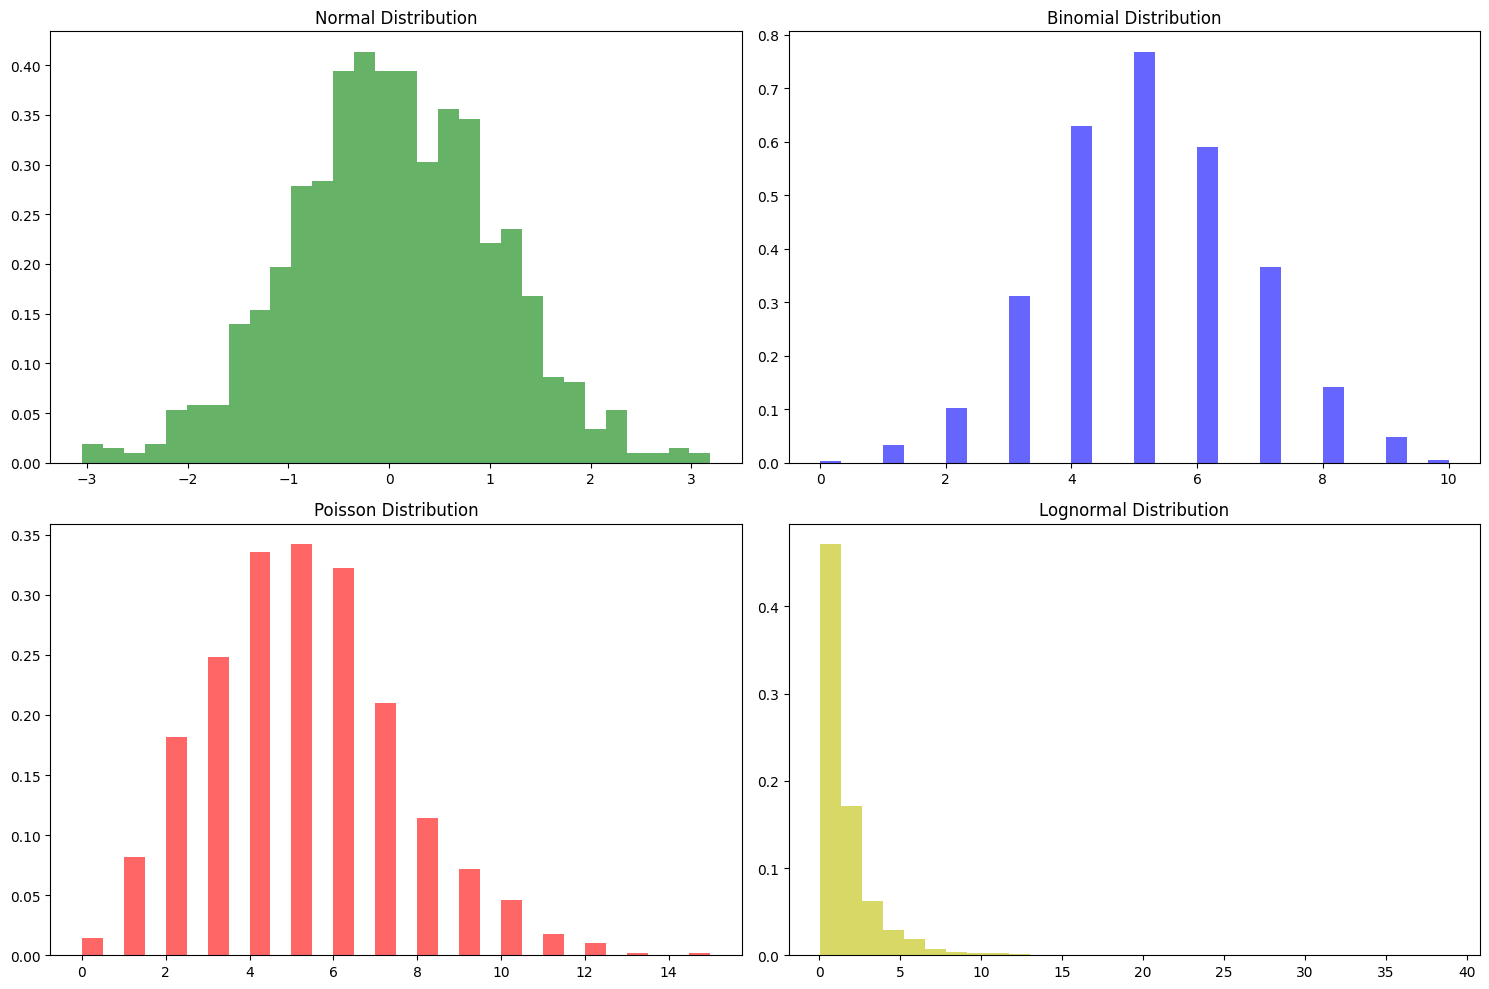

In [162]:
# Visualizar las distribuciones generadas
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(data_normal, bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution')

plt.subplot(2, 2, 2)
plt.hist(data_binomial, bins=30, density=True, alpha=0.6, color='b')
plt.title('Binomial Distribution')

plt.subplot(2, 2, 3)
plt.hist(data_poisson, bins=30, density=True, alpha=0.6, color='r')
plt.title('Poisson Distribution')

plt.subplot(2, 2, 4)
plt.hist(data_lognormal, bins=30, density=True, alpha=0.6, color='y')
plt.title('Lognormal Distribution')

plt.tight_layout()
plt.show()


In [165]:
data_binomial = np.random.binomial(n=20, p=0.5, size=5000)
binomial_model = BinomialDistribution(data_binomial)
print(binomial_model.fit_test())
print(binomial_model.normal_approximation())


{'p_value': np.float64(0.0), 'Result': np.False_, 'txt': 'Likelihod ratio (G2) test: chi2 157.73, p = 0.0000'}
{'Result': np.False_, 'txt': 'Not Binomial'}


In [163]:
# Generar datos de prueba
data_normal = Distribution(np.random.normal(loc=0, scale=1, size=1000))
data_binomial = Distribution(np.random.binomial(n=10, p=0.5, size=1000))
data_poisson = Distribution(np.random.poisson(lam=5, size=1000))
data_lognormal = Distribution(np.random.lognormal(mean=0, sigma=1, size=1000))
# Crear instancias de GoodnessAndFit con los datos generados
goodness_normal = GoodnessAndFit(data_normal)
goodness_binomial = GoodnessAndFit(data_binomial)
goodness_poisson = GoodnessAndFit(data_poisson)
goodness_lognormal = GoodnessAndFit(data_lognormal)

# Realizar las pruebas
print("GoodnessOfFit Normal Distribution:")
print(goodness_normal.evaluate_fit())
print(data_normal.type)
print(data_normal.aic_table)
print("")

print("GoodnessOfFit Binomial Distribution:")
print(goodness_binomial.evaluate_fit())
print(data_binomial.type)
print(data_binomial.aic_table)
print("")

print("GoodnessOfFit Poisson Distribution:")
print(goodness_poisson.evaluate_fit())
print(data_lognormal.type)
print(data_binomial.aic_table)
print("")

print("GoodnessOfFit Lognormal Distribution:")
print(goodness_lognormal.evaluate_fit())
print(data_lognormal.type)
print(data_binomial.aic_table)
print("")


GoodnessOfFit Normal Distribution:
{'type': {}, 'errors': {'BinomialDistribution': 'ValueError in BinomialDistribution: All values in data must be non-negative integers'}}
{}
{}

GoodnessOfFit Binomial Distribution:
{'type': {}, 'errors': {}}
{}
{}

GoodnessOfFit Poisson Distribution:
{'type': {}, 'errors': {}}
{}
{}

GoodnessOfFit Lognormal Distribution:
{'type': {}, 'errors': {}}
{}
{}



C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:370: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(self.data * np.log(self.lam) - self.lam - log_factorial)
C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after applying goodness of fit tests.", UserWarning)
C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after applying goodness of fit tests.", UserWarning)
C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\distributions.py:592: UserWarning: No valid distributions were found after applying goodness of fit tests.
  warnings.warn("No valid distributions were found after appl

TypeError: object of type 'Distribution' has no len()

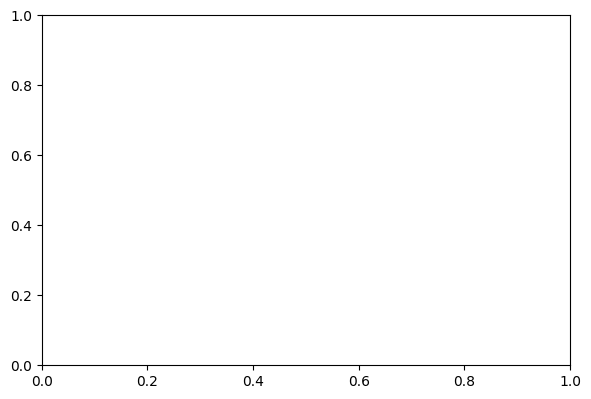

In [164]:
# Visualizar las distribuciones generadas
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(data_normal, bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution')

plt.subplot(2, 2, 2)
plt.hist(data_binomial, bins=30, density=True, alpha=0.6, color='b')
plt.title('Binomial Distribution')

plt.subplot(2, 2, 3)
plt.hist(data_poisson, bins=30, density=True, alpha=0.6, color='r')
plt.title('Poisson Distribution')

plt.subplot(2, 2, 4)
plt.hist(data_lognormal, bins=30, density=True, alpha=0.6, color='y')
plt.title('Lognormal Distribution')

plt.tight_layout()
plt.show()
